# Using Polytope package

In [1]:
"""How to compute a polytope's volume."""
import numpy as np
import polytope

# constructing a convex polytope and computing its volume
vertices = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
hull = polytope.qhull(vertices)
    # `hull` is an instance of the class `polytope.polytope.Polytope`
    # which is for representing a convex polytope
print(hull.volume)

# constructing a nonconvex polytope and computing its volume
vertices_1 = np.array([[0.0, 0.0], [0.0, 1.0], [2.0, 1.0]])
vertices_2 = np.array([[0.0, 1.0], [1.0, 1.0], [1.0, 2.0], [0.0, 2.0]])
hull_1 = polytope.qhull(vertices_1)  # convex hull of vertices in `vertices_1`
hull_2 = polytope.qhull(vertices_2)  # convex hull of vertices in `vertices_2`
nonconvex = hull_1.union(hull_2)  # construct union of convex polytopes
    # `nonconvex` is an instance of the class `polytope.polytope.Region`
    # which is for representing any polytope, including nonconvex ones,
    # and in this case can also be constructed with
    # `polytope.polytope.Region([hull_1, hull_2])`
print(polytope.volume( nonconvex ))

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


0.514
2.0440000000000005


In [2]:
polytope.volume(nonconvex, nsamples=50000)

2.0440000000000005

In [3]:
nonconvex.volume

2.0440000000000005

# Find Ellipse with cvxpy

In [4]:
import polytope as pt
# problem data
n = 2;
points = np.array
px = np.array([0, .5, 2, 3, 1]).reshape(-1,1);
py = np.array([0, 1, 1.5, .5, -.5]).reshape(-1,1);
points = np.append( px, py, axis=1 )
m = px.shape[1]
pxint = np.sum(px)/m; 
pyint = np.sum(py)/m;
px = np.append(px,  px[0])
py = np.append(py, py[0])

In [5]:
points

array([[ 0. ,  0. ],
       [ 0.5,  1. ],
       [ 2. ,  1.5],
       [ 3. ,  0.5],
       [ 1. , -0.5]])

In [6]:
 hull = pt.qhull(points)

In [7]:
A, b = hull.A, hull.b.reshape(-1,1)

In [8]:
import cvxpy as cp
# formulate and solve the problem
B = cp.Variable((n,n), symmetric=True)
d = cp.Variable((n,1))
objective = cp.Maximize( cp.log_det( B ) )
const = []
for i in range( points.shape[0] ):
    const += [ cp.norm( B @ A[i,:].reshape(-1,1) ) + A[i,:].reshape(1,-1) @ d <= b[i,0] ]
prob = cp.Problem( objective, const )
prob.solve()

-0.09773305109043312

# Finding circle with cvxpy

In [9]:
r = cp.Variable()
c = cp.Variable((2,1))
objective2 = cp.Maximize(r)
const2 = []
for i in range( points.shape[0] ):
    const2 += [ A[i,:].reshape(1,-1) @ c + np.linalg.norm(A[i,:]) * r <= b[i,0] ]
prob2 = cp.Problem( objective2, const2 )
prob2.solve()

0.7640840052119809

# Plot results

In [10]:
angles   = np.linspace( 0, 2 * np.pi, 100 )
ellipse_inner  = (B.value @ np.append(np.cos(angles).reshape(1,-1) , np.sin(angles).reshape(1,-1), axis=0 )) + d.value# * np.ones( 1, noangles );
ellipse_outer  = (2* B.value @ np.append(np.cos(angles).reshape(1,-1) , np.sin(angles).reshape(1,-1), axis=0 )) + d.value
circle_inner = c.value + r.value * np.append(np.cos(angles).reshape(1,-1) , np.sin(angles).reshape(1,-1), axis=0 )

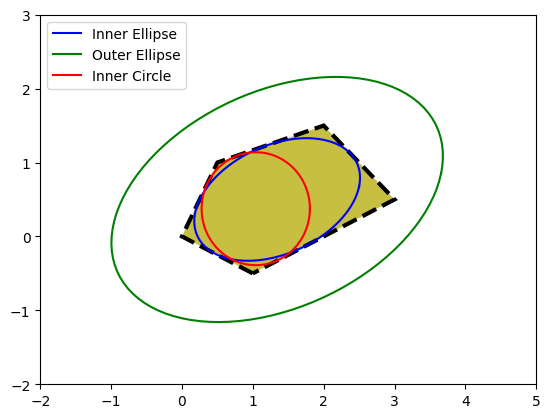

In [11]:
import matplotlib.pyplot as plt
plt.figure()
ax = plt.axes(xlim=(-2,5), ylim=(-2,3))
hull_plot = hull.plot(ax)
ax.plot( ellipse_inner[0,:], ellipse_inner[1,:], 'b', label='Inner Ellipse' )
ax.plot( ellipse_outer[0,:], ellipse_outer[1,:], 'g', label='Outer Ellipse' )
ax.plot( circle_inner[0,:], circle_inner[1,:], 'r', label='Inner Circle' )
ax.legend()
# hull_plot.clear()

# Polytope random function

In [12]:
import polytope as pc
A1 = np.array([[1.0, 0.0],
              [0.0, 1.0],
              [-1.0, -0.0],
              [-0.0, -1.0]])

b1 = np.array([2.0, 1.0, 0.0, 0.0])
p1 = pc.Polytope(A1, b1)

A2 = np.array([[1.0, 0.0],
              [0.0, 1.0],
              [-1.0, -0.0],
              [-0.0, -1.0]])

b2 = np.array([2.0, 1.0, 0.0, 0.0])
p2 = pc.Polytope(A2, b2)

In [25]:
p3 = p1.union(p2)

In [26]:
p3.volume

4.0

In [27]:
p3.A

AttributeError: 'Region' object has no attribute 'A'